# Important! 
When initially opening the notebook there should be a text to the right of the "Help" menu saying "Changes will not be saved". 
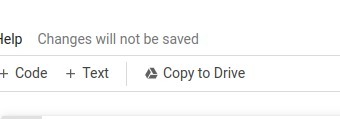

To ensure you can make changes to the notebook save a copy of it to your own drive and work on that one. You can do that by going to "File" -> "Save a copy in Drive".

**Failing to do so will result in code loss!**

 **Note** Make sure you are the only one that has access to it!

In [1]:
import torchvision.transforms as transforms

In [2]:
#@markdown #Image Processing - 67829. { display-mode: "form" }
#@markdown ##Exercise 5:  Deep Style Image Prior
#@markdown ##Due date: 26.01.2023 at 23:59
#@title{ display-mode: "form" }

#@markdown
#@markdown This exercise is a bit different than the rest of the exercises in the course.
#@markdown The submissions will be a PDF file with your answers and results to the exercise 
#@markdown as well as some files so that we can verify the authenticity of your results.
#@markdown This notebook provides the basic code, but you do not need to adhere to some specific API 
#@markdown and we will not be running unit tests on your code. 
#@markdown We will however, be going over your code and running it manually. 
#@markdown Moreover, we will be running tests to ensure the authenticity of your solution and detect plagiarism
#@markdown
#@markdown
#@markdown Before you start working on the exercise it is recommended that you review the lecture slides covering neural networks,
#@markdown
#@markdown 
#@markdown **NOTE**: Neural networks are typically trained on GPUs, without GPUs training takes much longer. 
#@markdown To enable GPU tranining click on "Runtime" -> "Change runtime type" -> "GPU" -> "SAVE".
#@markdown
#@markdown **NOTE**: A short guide on debugging your code using colab is availble [here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb#scrollTo=qnIn-rWFqoww).

#@markdown But first, we have to download all of the dependencies and install them.
#@markdown Play this cell to download it and get everything ready. markdown This may take a few minutes.

 
!mkdir impr_ex5_resources
%cd impr_ex5_resources
#!wget "https://www.cs.huji.ac.il/~impr/shape_predictor_68_face_landmarks.dat" -O shape_predictor_68_face_landmarks.dat 
#!wget "https://www.cs.huji.ac.il/~impr/align_faces.py" -O align_faces.py 
!wget "https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar" -O stylegan2-ada-pytorch.tar
!tar -xvf stylegan2-ada-pytorch.tar
!rm -f stylegan2-ada-pytorch.tar

import sys
ROOT_PATH="/content/impr_ex5_resources/stylegan2-ada-pytorch"
sys.path.append(ROOT_PATH)


!pip install ninja
!pip install mediapy
CHECKPOINTS_PATH = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"



import copy
import os
from time import perf_counter
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F

import dnnlib
import legacy
import numpy as np
from skimage.draw import line
from torch.nn.functional import conv2d,conv1d
from torch.nn import Conv2d
import mediapy as media
from IPython.display import clear_output
import matplotlib.pyplot as plt


/content/impr_ex5_resources
--2023-02-02 16:32:57--  https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar
Resolving www.cs.huji.ac.il (www.cs.huji.ac.il)... 132.65.118.16
Connecting to www.cs.huji.ac.il (www.cs.huji.ac.il)|132.65.118.16|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar [following]
--2023-02-02 16:32:58--  https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar
Reusing existing connection to www.cs.huji.ac.il:443.
HTTP request sent, awaiting response... 200 OK
Length: 100364800 (96M) [application/x-tar]
Saving to: ‘stylegan2-ada-pytorch.tar’

stylegan2-ada-pytor 100%[===================>]  95.71M  11.0MB/s    in 11s     

2023-02-02 16:33:09 (8.97 MB/s) - ‘stylegan2-ada-pytorch.tar’ saved [100364800/100364800]

stylegan2-ada-pytorch/
stylegan2-ada-pytorch/metrics/
stylegan2-ada-pytorch/._dataset_tool.py
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xat

# Mounting Google Drive

In [3]:
#@markdown **NOTE**: It is strongly advised you save your results to Google 
#@markdown Drive as they will be deleted from Colab once it restarts. 
#@markdown To connect Google Drive run this cell. 
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# General Variables

In [4]:
GAUSSIAN_BLUR_DEGRADATION= 'GAUSSIAN_BLUR_DEGRADATION'
GRAYSCALE_DEGRADATION = 'GRAYSCALE_DEGRADATION'
INPAINTING_DEGRADATION = 'INPAINTING_DEGRADATION'
NO_DEGRADATION= 'NO_DEGRADATION'


Below is the root dir of your Google Drive. To choose the destenation of the dir to save and read from, create it in your Google Drive and add the relative path to the "GDRIVE_SAVE_REL_PATH" variable below.

In [ ]:
ROOT_GDRIVE_PATH="/content/gdrive/MyDrive/"
GDRIVE_SAVE_REL_PATH = "Images/Colorization/Floki/Floki.png"
FULL_GDRIVE_SAVE_PATH = ROOT_GDRIVE_PATH + GDRIVE_SAVE_REL_PATH

# Image Alignment

In [5]:
# The align_faces.py script takes in an input image path, an output image path, and a dat file path. The dat file is already downloaded for you, so leave it as it is. 
# It is advised that you save the files to google drive as restarting Colab will erase them.
!python "$ROOT_PATH/align_faces/align_faces.py" '/content/gdrive/MyDrive/Images/Colorization/Floki/Floki2.png' '/content/gdrive/MyDrive/Images/Colorization/Floki/Floki_new_aligned.png' "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"

^C


# Degradation Functions 

In [5]:
    # ********************************************************************************************************
    # ******************                   NEED TO ADD DEGRADATION FUNCTIONS                ******************
    # ********************************************************************************************************
    # Define a function to apply the blur operation on the generated image

def gaussian(M, var=7):
  """
  Helper function that builds a Guassian function in torch.
  :param M: number of samples - kernel size.
  :param var: variance value of the Gaussian
  :return: Gassian in torch terms.
  """
  n = torch.arange(0, M) - (M - 1.0) / 2.0
  sigma_2 = 2 * var * var
  gauss = torch.exp(-n ** 2 / sigma_2)
  gauss = gauss / torch.sum(gauss)
  return gauss.type(torch.FloatTensor)

def create_blur_filter(ker_size, var=7):
  """
  Helper function that constructs a Guassian 1D kernel using torch library.
  :param ker_size: kernel size.
  :param var: variance value of the Gaussian.
  :return: Gaussian Kernel in torch terms - as 1D kernel.
  """
  ker_1d = torch.ones((1,ker_size))
  ker_1d[:,:] = gaussian(ker_size,var)
  return  ker_1d.to(device='cuda')
      
def apply_gaussian_blur(image, ker_size=25, var=7):
  """
  Helper function that constructs a Guassian 3D kernel using torch library.
  :param image: image as tensor to apply degrading on.
  :param ker_size: kernel size, default size is 25.
  :param var: variance value of the Gaussian, default size is 7.
  :return: Blurred Image according to constructed kernel with size and variance.
  """
  ker_RGB = create_blur_filter(ker_size, var).repeat((3, 1, 1, 1))
  kernel = ker_RGB.mT @ ker_RGB
  image = image.type(torch.FloatTensor).to(device='cuda')
  image = conv2d(image,weight=kernel,padding="same",groups=3)    
  return image

def apply_image_colorization(image):
  """
  Applies image colorization degrading on a given image.
  :param image: RGB color image as tensor to apply degrading on.
  :return: Degraded graysacle Image - takes an RGB colorized image and degrades
  it to a grayscale image.
  """
  # Multiply each of the RGB channels with the first row of YIQ Matrix in 
  # correspondence to Y channel with the matrix multiplication elements
  yiq_image = image[0,0]*0.2989 + image[0,1]*0.5870 + image[0,0]*0.114

  # Duplicate all 3 channels originally were RGB to Y Channel (stack image)
  return yiq_image.repeat(1,3,1,1)

def apply_inpainting_degredation(image):
  """
  Applies inpainting degredation on a given image.
  :param image: RGB color image as tensor to apply degrading on.
  :return: Degraded inpainting Image - takes an RGB image and applies a binary
  mask on it according to a given mask - result the original image but with
  missing piece coverd in black pixels.
  """
  target_fname = '/content/gdrive/MyDrive/Images/Inpainting/fei_fei/fei_fei_li_inpainting_mask.png'
  # target_pil = PIL.Image.open(target_fname).convert('RGB')
  
  # Read a PIL image
  mask = PIL.Image.open(target_fname).convert('L')
  
  # Define a transform to convert PIL 
  # image to a Torch tensor
  transform = transforms.Compose([transforms.PILToTensor()])
  
  # transform = transforms.PILToTensor()
  # Convert the PIL image to Torch tensor
  mask_tensor = transform(mask).to(device = 'cuda')
  
  # Convert mask to binary values
  mask_tensor = (mask_tensor > 0).int()
  
  # find tensor's image minimum value - reduce the minimum and after applying
  # dot with the mask - add the minimum - guarantee black (1 value) mask.
  min_val = image.min().item()
  return ((image - min_val) * mask_tensor) + min_val

# GAN Inversion

In [6]:
def run_latent_optimization(outdir,
    degradation_mode,
    G,
    imgs_to_disply_dict,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    latent_dist_reg_weight     = 0.001,
    device: torch.device
    
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore
  
    # Compute w stats.
    print(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 18, C]
    w_avg_original = torch.from_numpy(w_avg).to(device).float()
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)
    
    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)

    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) 
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
    
    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True
    loss_vector = []
    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth image from opt_w
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = w_opt + w_noise
        synth_images = G.synthesis(ws, noise_mode='const')
        
        # Prep to save synth image
        synth_image_save = (synth_images + 1) * (255/2)
        synth_image_save = synth_image_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    
    
        # ********************************************************************************************************
        # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
        # ********************************************************************************************************
        if  degradation_mode == INPAINTING_DEGRADATION:
            synth_images = apply_inpainting_degredation(synth_images)
        elif degradation_mode == GRAYSCALE_DEGRADATION:
            synth_images = apply_image_colorization(synth_images)
        elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
            synth_images = apply_gaussian_blur(synth_images,25,7)
        elif degradation_mode == NO_DEGRADATION:
            pass
        # ********************************************************************************************************
        # ******************                          END CODE TO ADD SECTION                   ******************
        # ********************************************************************************************************
         
        
        # Prep to save and show images
        synth_image_degraded_save = (synth_images + 1) * (255/2)
        synth_image_degraded_save = synth_image_degraded_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()  
        
        if step % 20 == 0:
          imgs_to_disply_dict["Generated Image"]=synth_image_save
          imgs_to_disply_dict["Generated Degraded Image"]=synth_image_degraded_save
          clear_output(wait=True)
          media.show_images(imgs_to_disply_dict,height=256)
        if step % 100 == 0:
          PIL.Image.fromarray(synth_image_save, 'RGB').save(f'{outdir}/intermidiate_%d_not_degraded.png'%step)
          PIL.Image.fromarray(synth_image_degraded_save, 'RGB').save(f'{outdir}/intermidiate_%d_degraded.png'%step)


        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        
        # Compute loss
        percep_loss = (target_features - synth_features).square().sum()
        latent_dist_reg = F.l1_loss(w_avg_original, w_opt)
        loss = percep_loss + reg_loss * regularize_noise_weight  + latent_dist_reg_weight * latent_dist_reg
        loss_vector.append(float(loss))


        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        print(f'step {step+1:>4d}/{num_steps}: percep_loss {percep_loss:<4.2f} latent_dist_reg {latent_dist_reg:<4.2f} loss {float(loss):<5.2f}' )

        # Save inverted latent for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()
    print(loss_vector)
    plot_loss(loss_vector, title="Loss over time (Log Scale)")
    return w_out

def plot_loss(losses, title="Loss over time (Log Scale)"):
  plt.plot(losses)
  plt.title(title)
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.yscale("log")
  plt.show()

In [7]:

def invert_image(degradation_mode,
                   target_fname,
                   outdir,
                   seed=303,
                   num_steps=1000,
                   latent_dist_reg_weight=0.001):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % CHECKPOINTS_PATH)
    device = torch.device('cuda')
    with dnnlib.util.open_url(CHECKPOINTS_PATH) as fp:
        networks = legacy.load_network_pkl(fp)
        G = networks['G_ema'].requires_grad_(False).to(device)
        

    # Load target image.
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    target = torch.tensor([target_uint8.transpose([2, 0, 1])], device=device)
    target_images = target[0].unsqueeze(0).to(device).to(torch.float32)

    # ********************************************************************************************************
    # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
    # ********************************************************************************************************
    if  degradation_mode == INPAINTING_DEGRADATION:
      target = apply_inpainting_degredation(target)
    elif degradation_mode == GRAYSCALE_DEGRADATION:
      target = apply_image_colorization(target)
    elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
      # In case we want to run the blur degredation on an already blurred image
      # uncomment 'pass' and comment out the 'apply_gaussian_blur'.
      # pass 
      target = apply_gaussian_blur(target,25,7)
    elif degradation_mode == NO_DEGRADATION:
      pass
    # ********************************************************************************************************
    # ******************                          END CODE TO ADD SECTION                   ******************
    # ********************************************************************************************************

    #Save target image
    target_to_save = target.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(target_to_save, 'RGB').save(f'{outdir}/original_degraded_image.png')
    imgs_to_disply_dict = {
        "Original Image":target_uint8,
        "Original Degraded Image":target_to_save,
              }

    # Run latent optimization
    start_time = perf_counter()
    optimization_steps = run_latent_optimization(
        outdir,
        degradation_mode,
        G,
        imgs_to_disply_dict,
        target[0],
        num_steps=num_steps,
        device=device,
        latent_dist_reg_weight=latent_dist_reg_weight
    )

    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')
    os.makedirs(outdir, exist_ok=True)

    # Save final inverted image and latent vector.
    inverted_latent = optimization_steps[-1]
    synth_image = G.synthesis(inverted_latent.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/final_inverted_image.png')
    np.savez(f'{outdir}/inverted_latent.npz', latent=inverted_latent.unsqueeze(0).cpu().numpy())


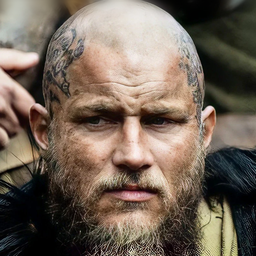
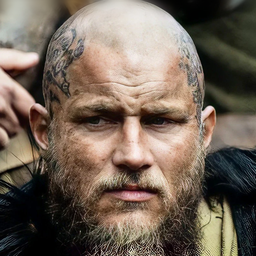
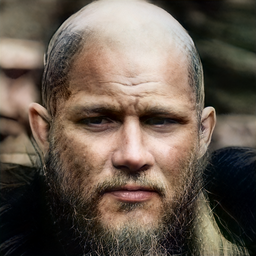
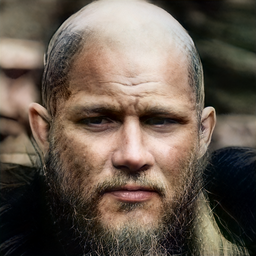

step  581/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  582/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  583/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  584/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  585/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  586/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  587/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  588/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  589/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  590/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  591/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  592/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  593/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  594/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  595/600: percep_loss 0.23 latent_dist_reg 0.99 loss 0.23 
step  596/600: percep_loss 0.23 latent_d

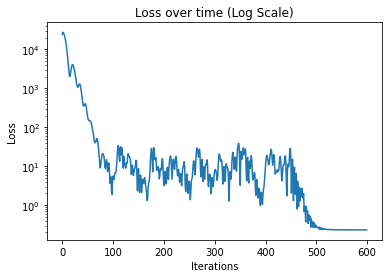

Elapsed: 160.6 s


In [ ]:
invert_image(NO_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/shaq/Ragnar_aligned.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/shaq/Ragnar_no_deg_NEW',303,600,0.001)

In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/shaq/Ragnar_aligned.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/shaq/Ragnar_blur_4',303,900,0.3)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...



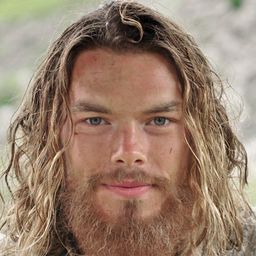
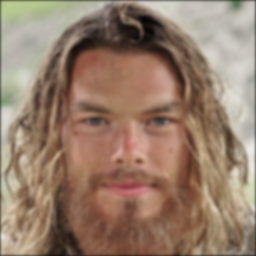
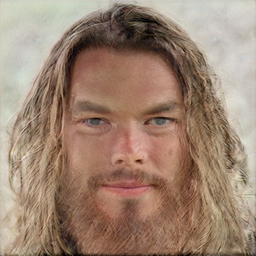
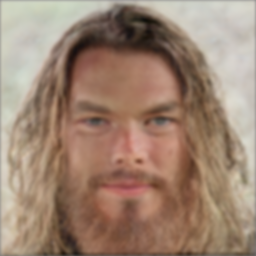

step  881/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  882/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  883/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  884/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  885/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  886/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  887/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  888/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  889/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  890/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  891/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  892/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  893/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  894/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  895/900: percep_loss 0.13 latent_dist_reg 0.94 loss 0.14 
step  896/900: percep_loss 0.13 latent_d

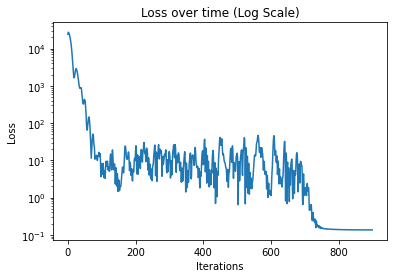

Elapsed: 257.3 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/Leif/Leif_aligned.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/Leif/Leif_Blurred4',303,900,0.01)


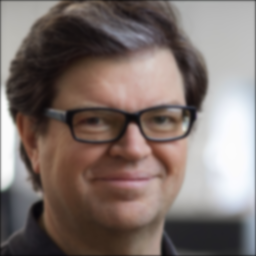
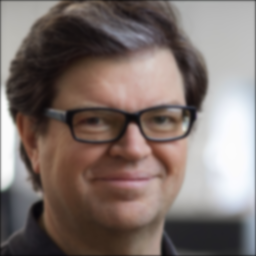
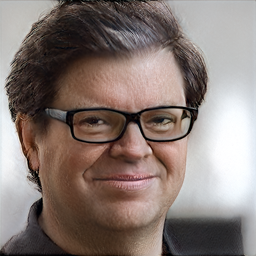
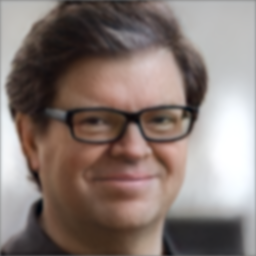

step  981/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  982/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  983/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  984/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  985/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  986/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  987/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  988/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  989/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  990/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  991/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  992/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  993/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  994/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  995/1000: percep_loss 0.08 latent_dist_reg 0.89 loss 0.08 
step  996/1000: percep_lo

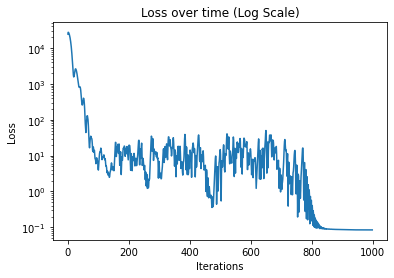

Elapsed: 303.2 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan37',303,900,0.01)


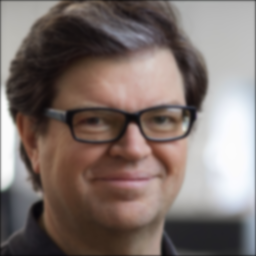
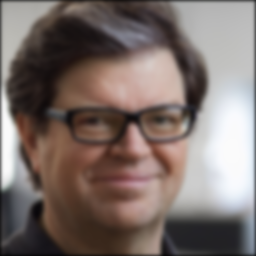
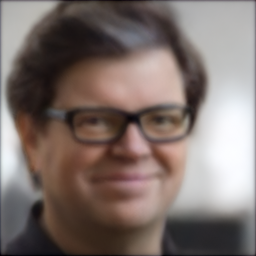
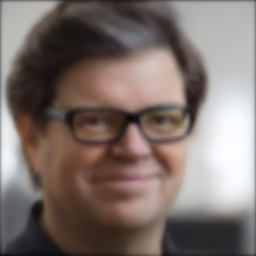

step  881/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  882/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  883/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  884/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  885/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  886/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  887/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  888/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  889/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  890/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  891/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  892/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  893/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  894/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  895/900: percep_loss 0.05 latent_dist_reg 1.03 loss 0.06 
step  896/900: percep_loss 0.05 latent_d

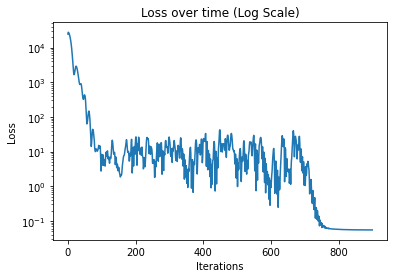

Elapsed: 243.3 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan5_5',303,900,0.01)


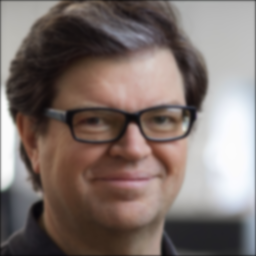
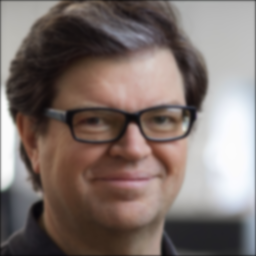
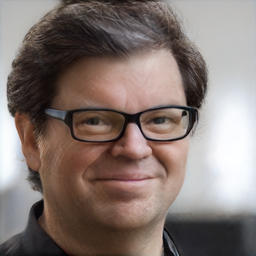
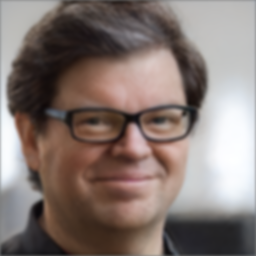

step  881/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  882/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  883/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  884/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  885/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  886/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  887/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  888/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  889/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  890/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  891/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  892/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  893/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  894/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  895/900: percep_loss 0.07 latent_dist_reg 0.17 loss 0.11 
step  896/900: percep_loss 0.07 latent_d

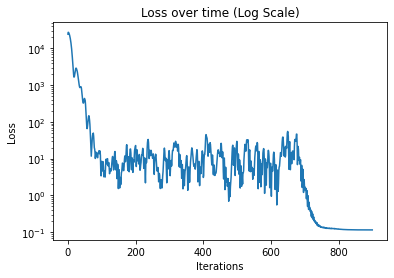

Elapsed: 254.6 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan25_7_NEW',303,900,0.25)


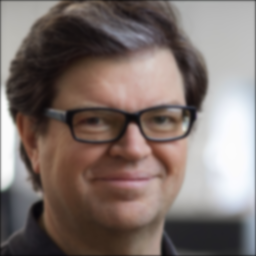
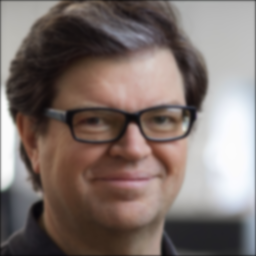
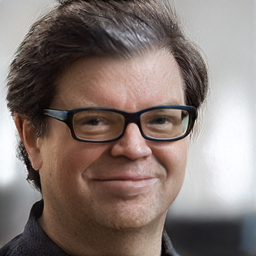
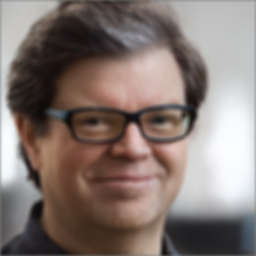

step  881/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  882/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  883/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  884/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  885/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  886/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  887/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  888/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  889/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  890/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  891/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  892/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  893/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  894/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  895/900: percep_loss 0.08 latent_dist_reg 0.16 loss 0.12 
step  896/900: percep_loss 0.08 latent_d

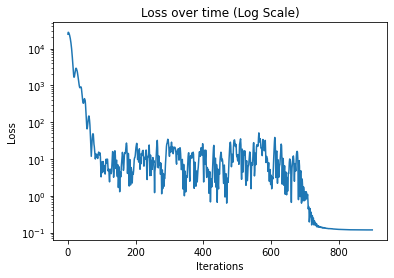

Elapsed: 255.2 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan25_11_NEW',303,900,0.25)


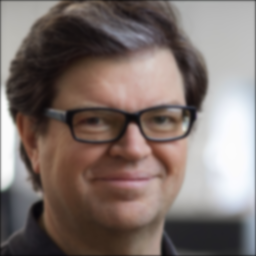
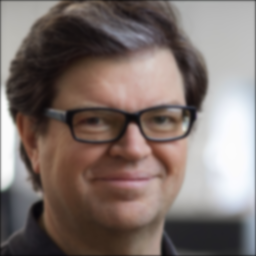
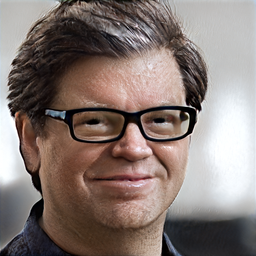
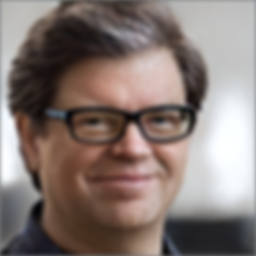

step  881/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  882/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  883/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  884/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  885/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  886/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  887/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  888/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  889/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  890/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  891/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  892/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  893/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  894/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  895/900: percep_loss 0.09 latent_dist_reg 0.17 loss 0.14 
step  896/900: percep_loss 0.09 latent_d

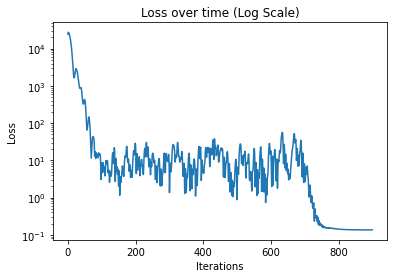

Elapsed: 276.0 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan41_11_NEW',303,900,0.25)


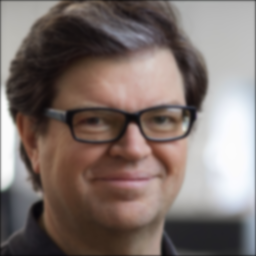
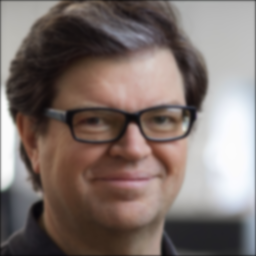
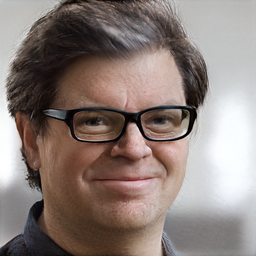
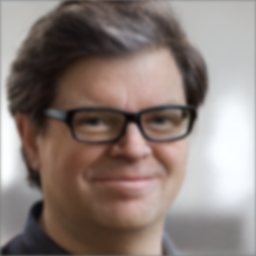

step  881/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  882/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  883/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  884/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  885/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  886/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  887/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  888/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  889/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  890/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  891/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  892/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  893/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  894/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  895/900: percep_loss 0.08 latent_dist_reg 0.17 loss 0.12 
step  896/900: percep_loss 0.08 latent_d

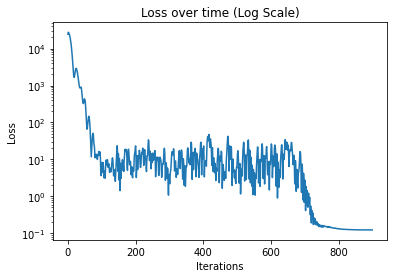

Elapsed: 272.8 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan41_7_NEW',303,900,0.25)


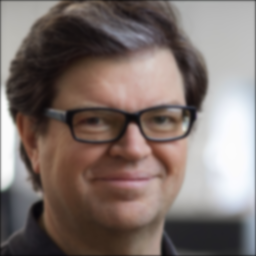
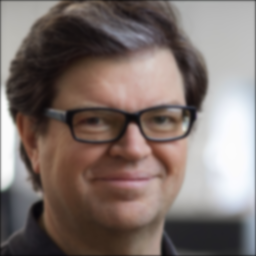
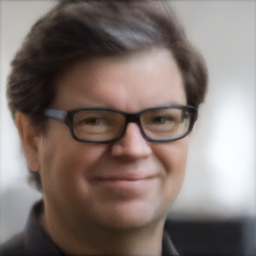
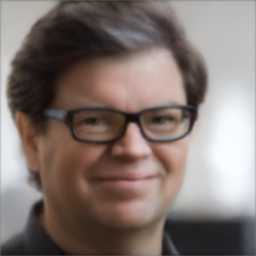

step  881/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  882/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  883/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  884/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  885/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  886/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  887/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  888/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  889/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  890/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  891/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  892/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  893/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  894/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  895/900: percep_loss 0.07 latent_dist_reg 0.18 loss 0.12 
step  896/900: percep_loss 0.07 latent_d

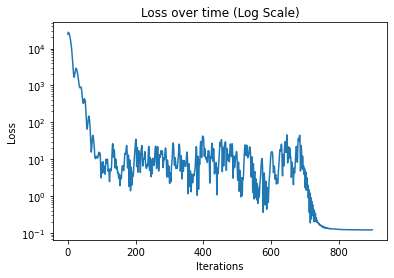

Elapsed: 273.3 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan41_3_NEW',303,900,0.25)


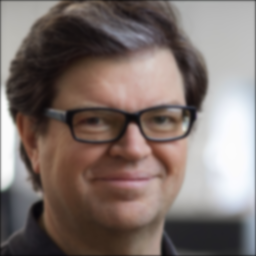
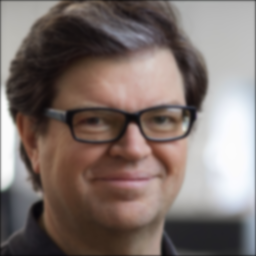
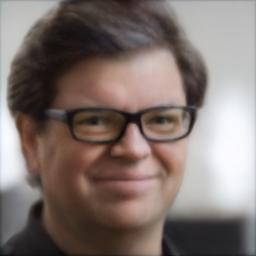
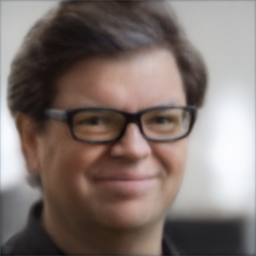

step  881/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  882/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  883/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  884/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  885/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  886/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  887/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  888/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  889/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  890/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  891/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  892/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  893/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  894/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  895/900: percep_loss 0.08 latent_dist_reg 0.18 loss 0.12 
step  896/900: percep_loss 0.08 latent_d

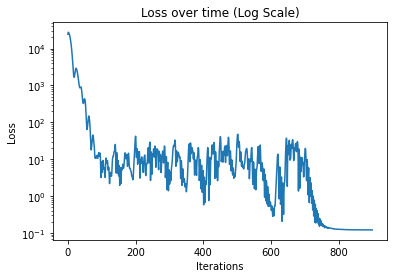

Elapsed: 241.8 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan5_11_NEW',303,900,0.25)


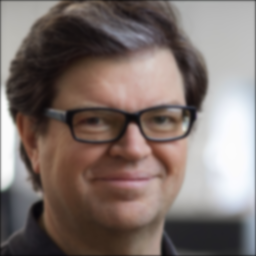
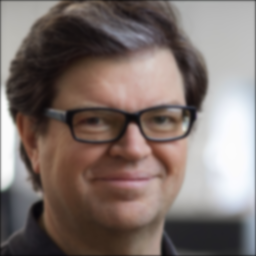
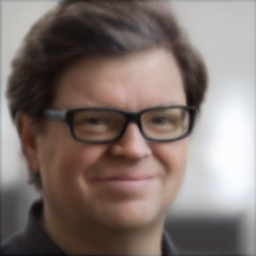
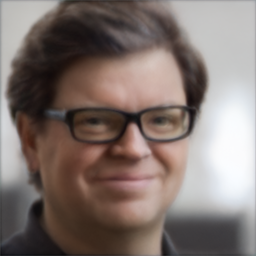

step  881/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  882/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  883/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  884/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  885/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  886/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  887/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  888/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  889/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  890/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  891/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  892/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  893/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  894/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  895/900: percep_loss 0.08 latent_dist_reg 0.19 loss 0.12 
step  896/900: percep_loss 0.08 latent_d

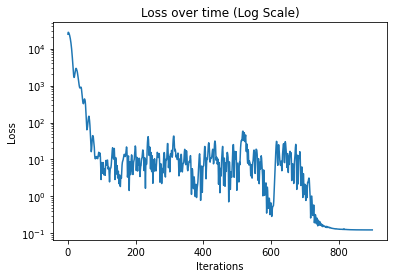

Elapsed: 244.6 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan5_7_NEW',303,900,0.25)


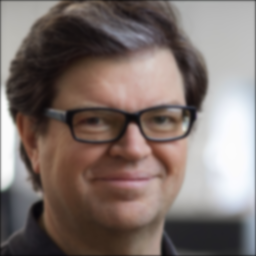
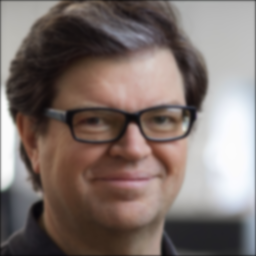
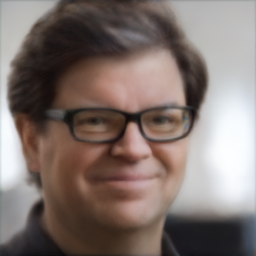
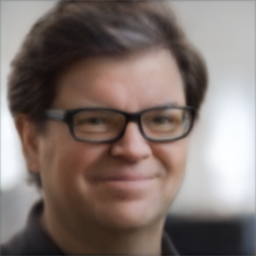

step  881/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  882/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  883/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  884/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  885/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  886/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  887/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  888/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  889/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  890/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  891/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  892/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  893/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  894/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  895/900: percep_loss 0.07 latent_dist_reg 0.19 loss 0.12 
step  896/900: percep_loss 0.07 latent_d

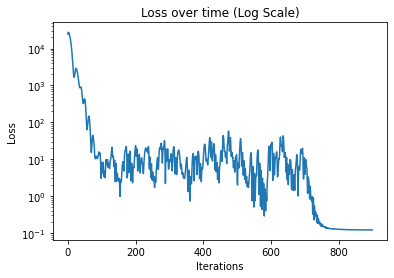

Elapsed: 242.8 s


In [ ]:
invert_image(GAUSSIAN_BLUR_DEGRADATION,'/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yann_lecun_blur.png','/content/gdrive/MyDrive/Images/Gaussian_Blur/yan/yan5_3_NEW',303,900,0.25)


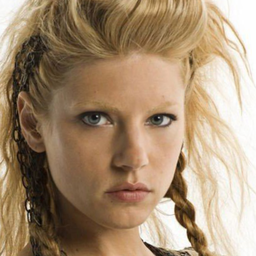
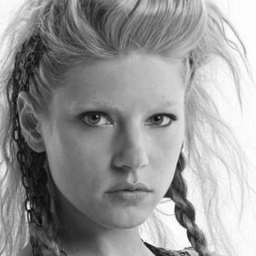
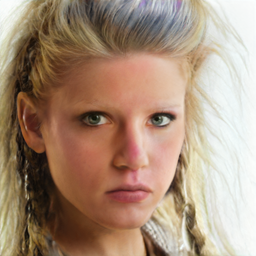
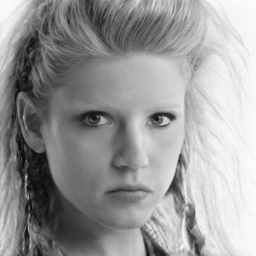

step  881/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  882/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  883/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  884/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  885/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  886/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  887/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  888/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  889/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  890/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  891/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  892/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  893/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  894/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  895/900: percep_loss 0.17 latent_dist_reg 0.13 loss 0.23 
step  896/900: percep_loss 0.17 latent_d

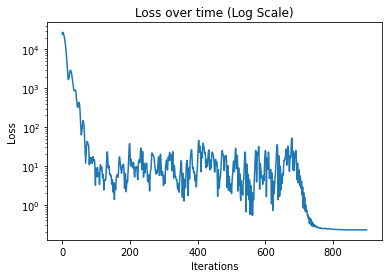

Elapsed: 234.6 s


In [ ]:
invert_image(GRAYSCALE_DEGRADATION,'/content/gdrive/MyDrive/Images/Colorization/Lagertha/Lagertha_aligned.png','/content/gdrive/MyDrive/Images/Colorization/Lagertha/Lagertha_color_NEW',303,900,0.4)


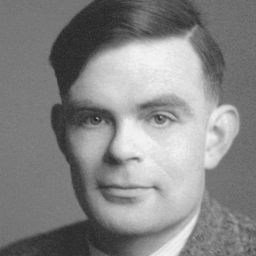
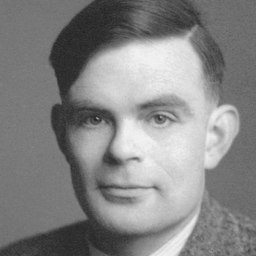
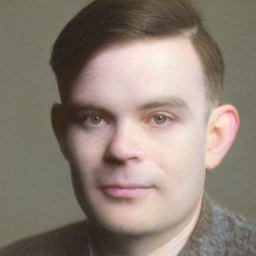
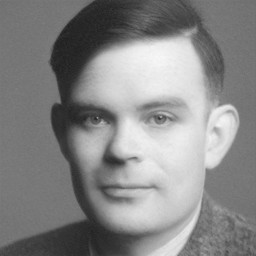

step  981/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  982/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  983/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  984/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  985/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  986/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  987/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  988/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  989/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  990/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  991/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  992/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  993/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  994/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  995/1000: percep_loss 0.12 latent_dist_reg 0.13 loss 0.15 
step  996/1000: percep_lo

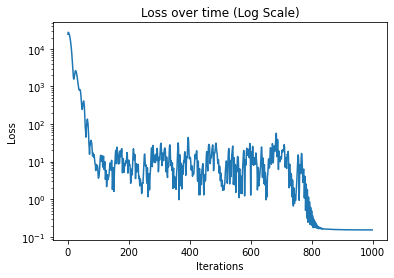

Elapsed: 259.5 s


In [ ]:
invert_image(GRAYSCALE_DEGRADATION,'/content/gdrive/MyDrive/Images/Colorization/alan_turing/alan_turing_grayscale.png','/content/gdrive/MyDrive/Images/Colorization/alan_turing/alan_turing_color5',303,900,0.27)


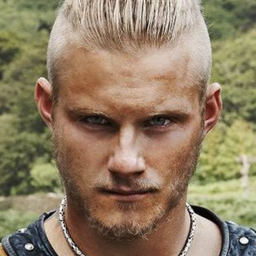
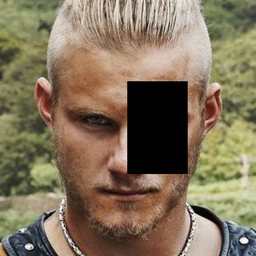
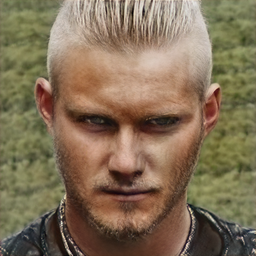
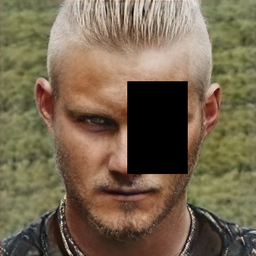

step  881/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  882/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  883/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  884/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  885/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  886/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  887/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  888/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  889/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  890/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  891/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  892/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  893/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  894/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  895/900: percep_loss 0.17 latent_dist_reg 0.43 loss 0.19 
step  896/900: percep_loss 0.17 latent_d

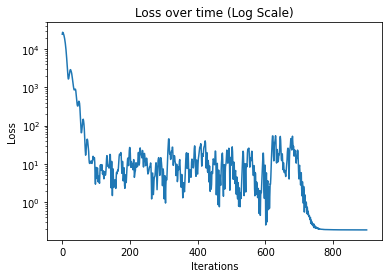

Elapsed: 246.1 s


In [ ]:
invert_image(INPAINTING_DEGRADATION,'/content/gdrive/MyDrive/Images/Inpainting/Bjorn/Bjorn_aligned.png','/content/gdrive/MyDrive/Images/Inpainting/Bjorn/Bjorn_Mask2',303,900,0.05)


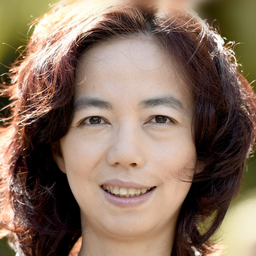
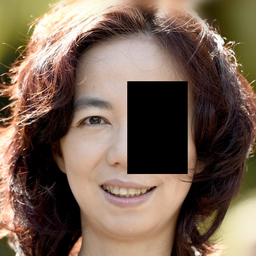
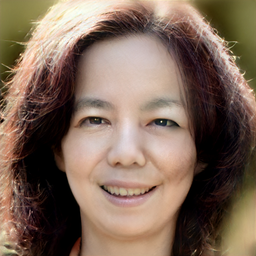
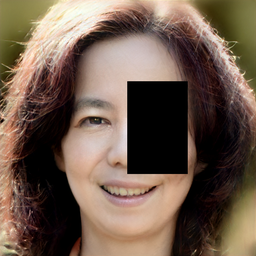

step  881/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  882/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  883/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  884/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  885/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  886/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  887/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  888/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  889/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  890/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  891/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  892/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  893/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  894/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  895/900: percep_loss 0.16 latent_dist_reg 0.95 loss 0.17 
step  896/900: percep_loss 0.16 latent_d

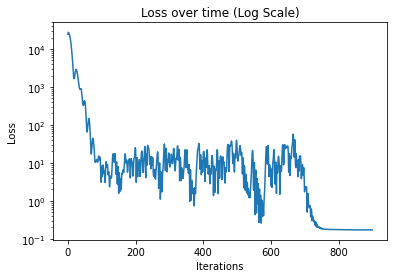

Elapsed: 233.0 s


In [ ]:
invert_image(INPAINTING_DEGRADATION,'/content/gdrive/MyDrive/Images/Inpainting/fei_fei/fei_fei_li_original.png','/content/gdrive/MyDrive/Images/Inpainting/fei_fei/fei_fei_li_inpainting',303,900,0.01)